# $$Advanced~~Topics~~in~~Financial~~Modelling~~Project$$

## Question 1 (Maths):

$$
x^\top \Sigma x 
=
X^\top \left( \begin{array}{cc} 
\Sigma & O_{nn} \\
O_{nn} & O_{nn} \\
\end{array} \right) X
$$
Where
$$
X = \left( \begin{array}{c} 
x \\
|x| \\
\end{array} \right)
$$

$$
\sum_{i} x_i = 1 \Leftrightarrow \mathbf{1}^\top x = 1 \Leftrightarrow \left( \begin{array}{c} 
\mathbf{1} \\
0 \\
\end{array} \right)^\top X = 1
$$
$$
\sum_{i} |x_i| \leq \text{e_max}  \Leftrightarrow \left( \begin{array}{c} 
1 \\
0 \\
\end{array} \right)^\top X \leq \text{e_max}
$$

New Constraints:
$$
\left\{
\begin{array}{l} 
|x_i| - x_i \geq 0 \\
|x_i| - x_i \leq 0 \\
\end{array} 
\right.
\Leftrightarrow 
\left( \begin{array}{c} 
0_{nn} \\
0_{nn} \\
\end{array} \right) \leq 
\left( \begin{array}{cc} 
-I_{nn} & I_{nn} \\
I_{nn} & I_{nn} \\
\end{array} \right) X \leq 
\left( \begin{array}{c} 
+\infty \\
+\infty \\
\end{array} \right).
$$


$$
\left\{
\begin{array}{l}
\sum_{i} |x_i| \leq \text{e_max} \\
\sum_{i} x_i = 1
\end{array}
\right.
\Leftrightarrow \left( \begin{array}{c} 
1\\
-\infty \\
\end{array} \right) \leq \left( \begin{array}{cc} 
I_{n n} & 0_{n n} \\
0_{n n} & I_{n n} \\
\end{array} \right) X \leq \left( \begin{array}{c} 
1 \\
\text{e_max} \\
\end{array} \right).
$$

we then deduce that 

The simplified constraints can be encapsulated as:
$$
\left\{
\begin{array}{l}
\sum_{i} |x_i| \leq \text{e_max} \\
\sum_{i} x_i = 1 \\
|x_i| - x_i \geq 0 \\
|x_i| - x_i \leq 0 \\
\end{array}
\right.
\Leftrightarrow \left( \begin{array}{c} 
1\\
-\infty \\
0_{nn}\\
0_{nn} \\
\end{array} \right) \leq \left( \begin{array}{cc} 
I_{nn} & 0_{nn} \\
0_{nn} & I_{nn} \\
-I_{nn} & I_{nn} \\
I_{nn} & I_{nn} \\
\end{array} \right) X \leq \left( \begin{array}{c} 
1 \\
\text{e_max} \\
+\infty \\
+\infty \\
\end{array} \right).
$$

# Code part

## Import required libraries

In [1]:
import pandas as pd
import numpy as np
import osqp
from scipy import sparse as sp
import matplotlib.pyplot as plt

### Data Loading and Initial Processing

In [2]:
# Load historical stock returns and stock information
stock_info = pd.read_csv('US_stocks_info_clean.csv')
historical_data = pd.read_csv('US_stocks_histo_clean.csv')

In [3]:
# Preview initial rows to understand data structure
stock_info.head()
historical_data.drop(columns=['Unnamed: 0'], inplace=True)  # Clean up unnecessary columns
historical_data['ref_date'] = pd.to_datetime(historical_data['ref_date'])  # Convert 'ref_date' to datetime
historical_data.set_index('ref_date', inplace=True)
historical_data.head()

,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZION,ZTS
ref_date,,,,,,,,,,,,,,,,,,,,,
2020-03-19,10.29,59.683468,59.672993,69.601639,27.059999,149.671768,307.510010,84.285378,30.261745,108.561790,...,13.958945,46.217190,52.035137,28.076918,61.599167,58.432629,83.948914,185.070007,23.905647,99.462814
2020-03-20,10.38,55.894428,57.791939,63.529007,25.969999,141.588547,295.339996,79.395500,27.684156,103.650299,...,12.765431,51.565205,45.430923,26.698755,57.231991,54.213528,80.972939,179.380005,22.440605,98.111740
2020-03-23,10.25,54.706989,54.164204,58.689583,23.260000,135.686646,307.269989,79.470139,26.508413,100.884682,...,11.649755,57.121586,44.865604,25.646791,54.126236,52.757385,76.104004,170.720001,21.124693,90.063759
2020-03-24,13.92,60.195496,56.675056,65.107903,25.600000,148.113678,310.000000,87.467552,29.230709,111.882370,...,14.598948,66.041557,48.499722,28.900549,59.248341,65.022636,87.960838,180.550003,22.089697,100.852753
2020-03-25,15.39,59.863895,57.027771,66.098183,25.719999,143.363846,305.910004,88.055450,29.574385,113.390045,...,15.325438,74.475349,49.845688,30.409182,61.025791,68.018944,91.191086,186.229996,22.677467,105.178055


In [4]:
# Compute log returns and filter returns before the in-sample cutoff date
returns = historical_data.pct_change().dropna()
pre_cutoff_returns = returns[returns.index < '2022-03-25']
cov_matrix_pre = pre_cutoff_returns.cov()  # Covariance matrix of returns

### Portfolio Optimization Class

In [5]:
class PortfolioOptimizer:
    # Class to handle the computation of minimum variance portfolio weights and exposures
    def __init__(self, returns):
        self.returns = returns
        self.cov_matrix = returns.cov()
        
    def minimum_variance_weights(self):
        # Calculate minimum variance portfolio weights
        inv_cov_matrix = np.linalg.pinv(self.cov_matrix.values)
        num_assets = len(self.cov_matrix)
        ones_vector = np.ones(num_assets)
        numerator = np.dot(inv_cov_matrix, ones_vector)
        denominator = np.dot(ones_vector.T, numerator)
        return numerator / denominator

    def net_exposure(self):
        # Calculate net exposure of the portfolio
        weights = self.minimum_variance_weights()
        return np.sum(weights)

    def gross_exposure(self):
        # Calculate gross exposure of the portfolio
        weights = self.minimum_variance_weights()
        absolute_weights = np.abs(weights)
        return np.sum(absolute_weights)

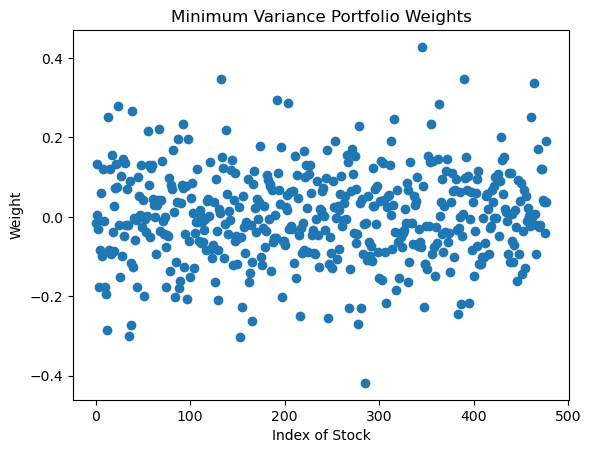

In [6]:
# Instantiate optimizer and compute portfolio metrics
optimizer = PortfolioOptimizer(pre_cutoff_returns)
min_var_weights = optimizer.minimum_variance_weights()

# Plotting the weights of the minimum variance portfolio
plt.scatter(range(len(min_var_weights)), min_var_weights)
plt.title("Minimum Variance Portfolio Weights")
plt.xlabel("Index of Stock")
plt.ylabel("Weight")
plt.show()

### Setting Up the Quadratic Programming Problem

In [7]:
# Construct quadratic program matrices for the minimum variance problem
P_upper_left = optimizer.cov_matrix.values
zero_matrix = np.zeros_like(P_upper_left)
P = np.block([[P_upper_left, zero_matrix], [zero_matrix, zero_matrix]])

identity_matrix = np.eye(len(P_upper_left))
vector_of_ones = np.ones(len(P_upper_left))
vector_of_zeros = np.zeros(len(P_upper_left))
matrix_A_part = np.block([[-identity_matrix, identity_matrix], [identity_matrix, identity_matrix]])
vector_A_top = np.concatenate((vector_of_ones, vector_of_zeros))
vector_A_bottom = np.concatenate((vector_of_zeros, vector_of_ones))
A = np.vstack((vector_A_top, vector_A_bottom, matrix_A_part))

l_bound = np.concatenate(([1, -np.inf], vector_of_zeros, vector_of_zeros))
emax = 10
infinity_vector = np.full(len(P_upper_left), np.inf)
u_bound = np.concatenate(([1, emax], infinity_vector, infinity_vector))

In [8]:
# Setup and solve the quadratic program using OSQP
problem = osqp.OSQP()
problem.setup(sp.csc_matrix(P), np.zeros(2 * len(P_upper_left)), sp.csc_matrix(A), l_bound, u_bound, alpha=1.0, scaling=10)
solution = problem.solve()

re_dimensioned_weights = solution.x[:len(P_upper_left)]
print("Net exposure using re-dimensioned solution: ", np.sum(re_dimensioned_weights))
print("Net exposure from analytical formula: ", optimizer.net_exposure())

absolute_re_dimensioned_weights = np.abs(re_dimensioned_weights)
gross_re_dimensioned_exposure = np.sum(absolute_re_dimensioned_weights)
print("Gross exposure using re-dimensioned solution: ", gross_re_dimensioned_exposure)
print("Gross exposure from analytical formula: ", optimizer.gross_exposure())

-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 956, constraints m = 958
          nnz(P) + nnz(A) = 117349
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.00, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.00e+00   1.00e+02   1.00e-01   4.95e-02s
 200   8.4002e-06   1.88e-02   2.16e-07   5.34e-04   2.00e-01s
 300   5.1368e-06   1.04e-03   1.52e-06   

### Solving the Quadratic Program for Different 'emax' Values and Storing Results

In [9]:
# Creating arrays to handle different emax values
emax_values = np.array([i/2 for i in range(2, 21)])  # emax ranging from 1 to 10 in increments of 0.5
solutions = []

In [10]:
# Solving the quadratic program for each emax value and storing results
for emax in emax_values:
    u_bound[1] = emax  # update the emax in the upper bounds
    problem.update(u=u_bound)
    res = problem.solve()
    solutions.append(res.x[:len(P_upper_left)])  # store only the portfolio weights, not slack variables

iter   objective    pri res    dua res    rho        time
   1   5.0394e-06   8.99e+00   4.80e-03   5.34e-04   2.77e-03s
  25   2.7621e-05   1.37e-03   1.34e-06   5.34e-04   1.81e-02s

status:               solved
number of iterations: 25
optimal objective:    0.0000
run time:             1.82e-02s
optimal rho estimate: 1.76e-04

iter   objective    pri res    dua res    rho        time
   1   2.7631e-05   4.63e-02   2.61e-05   5.34e-04   1.26e-03s
  25   2.3232e-05   8.47e-04   1.90e-06   5.34e-04   1.62e-02s

status:               solved
number of iterations: 25
optimal objective:    0.0000
run time:             1.63e-02s
optimal rho estimate: 8.22e-05

iter   objective    pri res    dua res    rho        time
   1   2.3009e-05   2.42e-02   1.45e-05   5.34e-04   1.93e-03s
  25   1.7256e-05   2.04e-04   7.54e-06   5.34e-04   1.48e-02s

status:               solved
number of iterations: 25
optimal objective:    0.0000
run time:             1.49e-02s
optimal rho estimate: 1.50e-05

iter

In [11]:
# Create a DataFrame to display the weights for each emax
weights_df = pd.DataFrame(np.array(solutions).T, columns=[f'emax={emax}' for emax in emax_values])
weights_df.insert(0, 'ticker', stock_info['ticker'])
weights_df.head()

,ticker,emax=1.0,emax=1.5,emax=2.0,emax=2.5,emax=3.0,emax=3.5,emax=4.0,emax=4.5,emax=5.0,emax=5.5,emax=6.0,emax=6.5,emax=7.0,emax=7.5,emax=8.0,emax=8.5,emax=9.0,emax=9.5,emax=10.0
0,AAL,-0.000052,-0.000025,0.007640,0.010669,1.238542e-02,0.013825,0.014630,1.446947e-02,1.392229e-02,0.013182,0.012454,0.011748,0.011086,1.046029e-02,9.907550e-03,9.358180e-03,8.801160e-03,8.271119e-03,7.760203e-03
1,AAPL,0.000041,-0.000090,0.000007,-0.000007,-5.477441e-06,-0.000011,-0.000002,2.676762e-08,7.535988e-07,0.000001,0.000002,0.000001,0.000002,1.993044e-06,2.132814e-06,2.774879e-06,3.061155e-06,3.087925e-06,2.775699e-06
2,ABBV,-0.000036,-0.000358,0.002373,0.008065,1.149687e-02,0.013661,0.015027,1.535624e-02,1.506597e-02,0.014594,0.014359,0.014265,0.014296,1.440077e-02,1.446457e-02,1.442872e-02,1.429614e-02,1.418098e-02,1.408908e-02
3,ABT,-0.000044,-0.000190,0.000016,-0.000004,6.818658e-07,0.000006,0.000003,9.905809e-07,3.555816e-06,0.000003,0.000002,0.000001,0.000001,8.382791e-07,5.006799e-07,3.234976e-07,6.731397e-07,5.833975e-07,5.685244e-07
4,ACGL,0.000067,-0.000090,0.000092,0.000034,1.579413e-05,0.000012,0.000007,6.066673e-06,6.042411e-06,0.000005,0.000005,0.000003,0.000002,1.753613e-06,1.318227e-06,8.831824e-07,2.811554e-07,8.176718e-07,1.282845e-06


### Computing and Plotting In-Sample Volatility for Each Solution

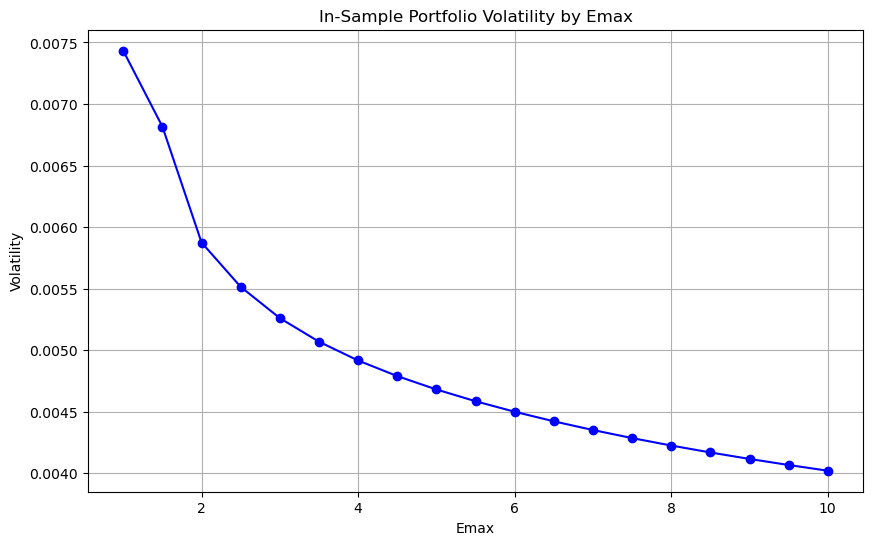

In [12]:
def portfolio_volatility(weights, covariance_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))

in_sample_volatility = [portfolio_volatility(weights, cov_matrix_pre) for weights in solutions]

# Plotting in-sample volatility against emax values
plt.figure(figsize=(10, 6))
plt.plot(emax_values, in_sample_volatility, marker='o', linestyle='-', color='blue')
plt.title('In-Sample Portfolio Volatility by Emax')
plt.xlabel('Emax')
plt.ylabel('Volatility')
plt.grid(True)
plt.show()

### Computing and Plotting the Number of Stocks for Each Solution

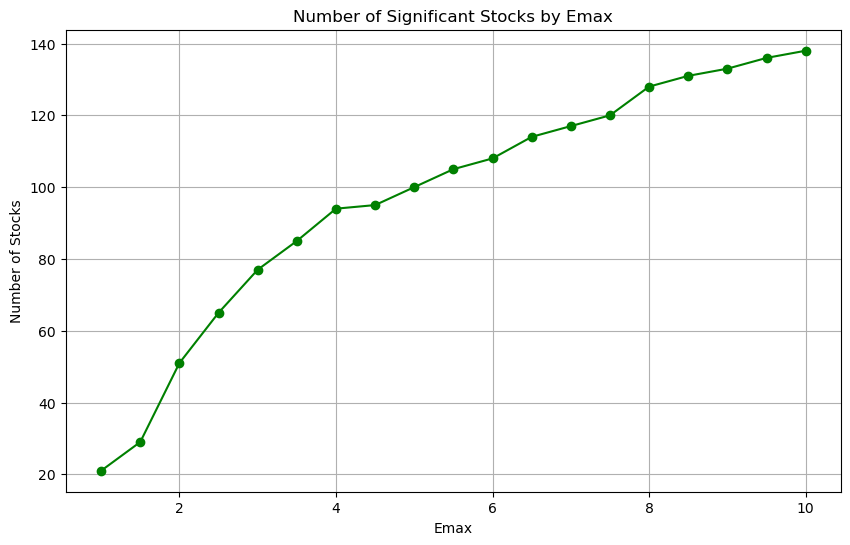

In [13]:
# Calculating the number of significant weights (stocks) in each portfolio
number_of_stocks = [np.count_nonzero(np.abs(weights) > 0.01) for weights in solutions]

# Plotting the number of stocks in the portfolio by emax
plt.figure(figsize=(10, 6))
plt.plot(emax_values, number_of_stocks, marker='o', linestyle='-', color='green')
plt.title('Number of Significant Stocks by Emax')
plt.xlabel('Emax')
plt.ylabel('Number of Stocks')
plt.grid(True)
plt.show()

### Out-of-Sample Analysis

In [14]:
# Filter returns after the cutoff date and compute the covariance matrix
post_cutoff_returns = returns[returns.index >= '2022-03-25']
cov_matrix_post = post_cutoff_returns.cov()

# Calculate out-of-sample volatility
out_of_sample_volatility = [portfolio_volatility(weights, cov_matrix_post) for weights in solutions]

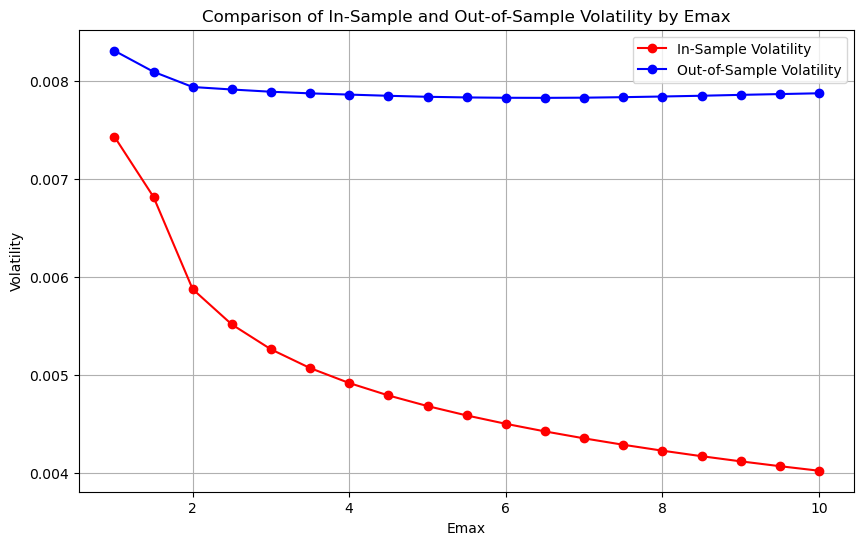

In [15]:
# Plotting in-sample and out-of-sample volatilities
plt.figure(figsize=(10, 6))
plt.plot(emax_values, in_sample_volatility, marker='o', linestyle='-', label='In-Sample Volatility', color='red')
plt.plot(emax_values, out_of_sample_volatility, marker='o', linestyle='-', label='Out-of-Sample Volatility', color='blue')
plt.title('Comparison of In-Sample and Out-of-Sample Volatility by Emax')
plt.xlabel('Emax')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

### Analysis of Portfolio at Emax=1

In [16]:
# Assuming 'emax=1' corresponds to the first solution in the array
selected_weights = solutions[0]
selected_tickers = weights_df[['ticker', 'emax=1.0']]

# Merging selected weights with stock information to analyze sectors and other metrics
portfolio_details = pd.merge(selected_tickers, stock_info, on='ticker')
portfolio_details.drop(columns=['Unnamed: 0'], inplace=True)
portfolio_details.set_index('ticker', inplace=True)
portfolio_details.head()


,emax=1.0,name,sector,industry,PE_ratio,market_cap,short_name
ticker,,,,,,,
AAL,-0.000052,"American Airlines Group, Inc.",Industrials,Airlines,5.748954,8.979647e+09,Ameri. Air.
AAPL,0.000041,Apple Inc.,Technology,Consumer Electronics,31.407830,2.994371e+12,Apple
ABBV,-0.000036,AbbVie Inc.,Healthcare,Drug Manufacturers—General,42.457534,2.736053e+11,AbbVie
ABT,-0.000044,Abbott Laboratories,Healthcare,Medical Devices,37.438776,1.910880e+11,Abbott Lab.
ACGL,0.000067,Arch Capital Group Ltd.,Financial Services,Insurance—Diversified,9.583226,2.771548e+10,Arch Capit.


### Sector Bias Analysis

### Weights Analysis

To assess the sectoral distribution of our portfolio, we have created a diagram illustrating the weights assigned to each sector.

We observe a notable concentration in the "consumer defensive" sector. This concentration can be explained by the fact that companies in this sector tend to have lower volatility. This observation is consistent with the objective of our portfolio, which aims to minimize variance.

In [17]:
# Grouping by sector to see the distribution of weights across different sectors
sector_weights = portfolio_details.groupby('sector')['emax=1.0'].sum()

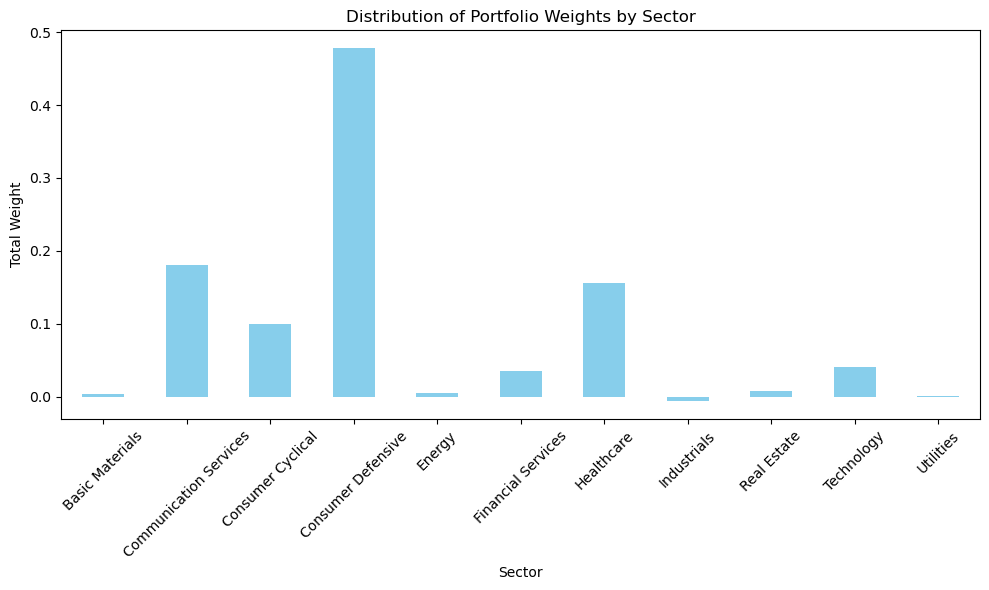

In [18]:
# Plotting the distribution of weights by sector
plt.figure(figsize=(10, 6))
sector_weights.plot(kind='bar', color='skyblue')
plt.title('Distribution of Portfolio Weights by Sector')
plt.xlabel('Sector')
plt.ylabel('Total Weight')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Market Capitalization Analysis

We have created a diagram illustrating the distribution of market capitalization by sector in our portfolio.

We observe a strong bias towards the technology sector. This observation may seem surprising given that technology companies represent only a small weighting in our portfolio. However, this is explained by the fact that technology companies generally have, by far, the largest market capitalizations in the world.

In [19]:
# Calculating the total market cap per sector and comparing it with the portfolio weights
market_cap_by_sector = portfolio_details.groupby('sector')['market_cap'].sum()

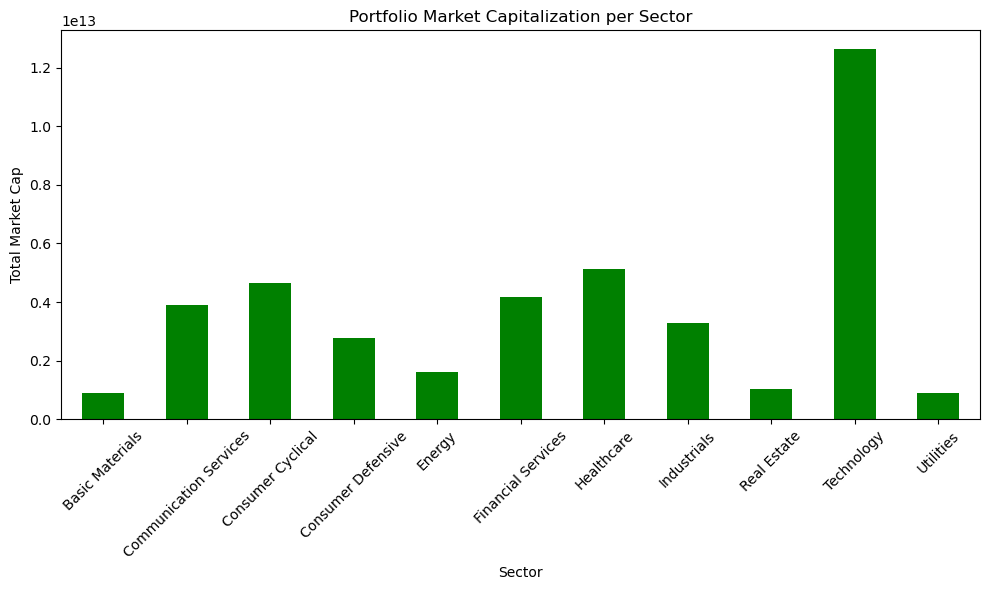

In [20]:
# Plotting the normalized weights by market cap
plt.figure(figsize=(10, 6))
market_cap_by_sector.plot(kind='bar', color='green')
plt.title('Portfolio Market Capitalization per Sector')
plt.xlabel('Sector')
plt.ylabel('Total Market Cap')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Indeed, if we look at companies with such high market capitalization that they could influence our portfolio even in small quantities (let's take: market_cap $\geq 10^{12}$), we find that they are almost exclusively from the technology sector:

In [21]:
above_threshold_market_cap = portfolio_details[portfolio_details['market_cap'] >= 10**12]

mktcap_above_by_sector = above_threshold_market_cap['sector'].value_counts()
mktcap_above_by_sector

Technology                3
Consumer Cyclical         1
Communication Services    1
Name: sector, dtype: int64

### PE Ratio Distribution Analysis

We have created a diagram illustrating the distribution of market capitalization by sector in our portfolio.

We observe a strong bias towards the technology sector, which is consistent with its importance in terms of valuation. Indeed, technology companies are among the most highly valued in the market.

However, we also note a significant influence from the Real Estate sector, despite its low weighting in terms of both weight and market capitalization in our portfolio. This observation could be explained by investors' confidence in strong growth in the real estate market, which could lead to increased valuation of companies in this sector.

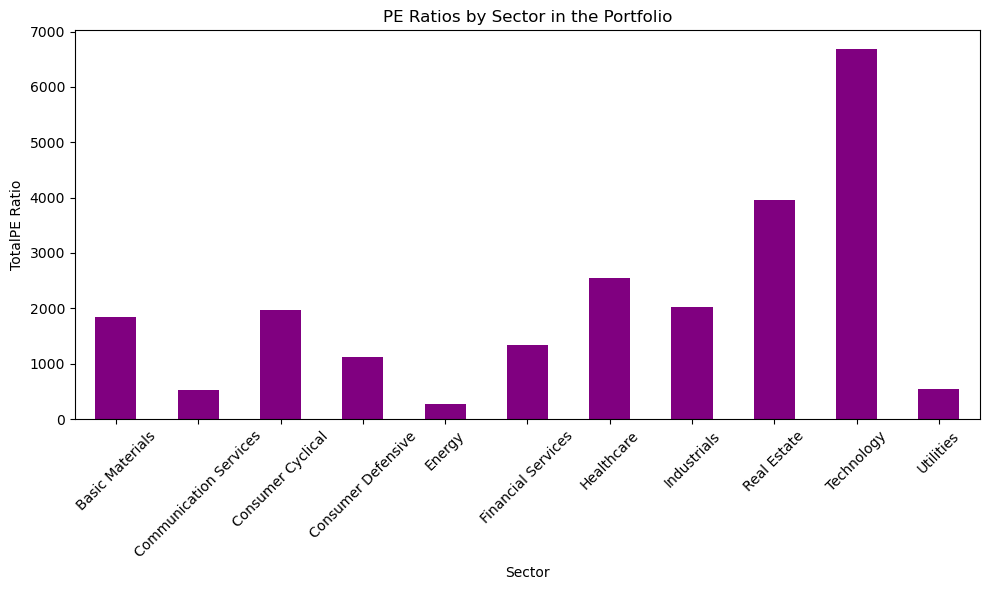

In [22]:
# Analyzing the PE Ratio distribution within the portfolio
pe_ratios = portfolio_details.groupby('sector')['PE_ratio'].sum()

# Plotting the average PE Ratios by sector within the portfolio
plt.figure(figsize=(10, 6))
pe_ratios.plot(kind='bar', color='purple')
plt.title('PE Ratios by Sector in the Portfolio')
plt.xlabel('Sector')
plt.ylabel('TotalPE Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Indeed, when considering the average PE ratio by sector (next diagram), we observe that real estate companies tend to have a higher PE ratio on average compared to tech companies. This trend is also evident among basic materials companies, although it does not significantly impact the portfolio due to their relatively small total weights, as illustrated in the weight diagrams.

Furthermore, it's worth noting that the market capitalization of basic materials companies is not substantial enough to counterbalance this trend, unlike tech companies, as depicted in the market capitalization diagram.

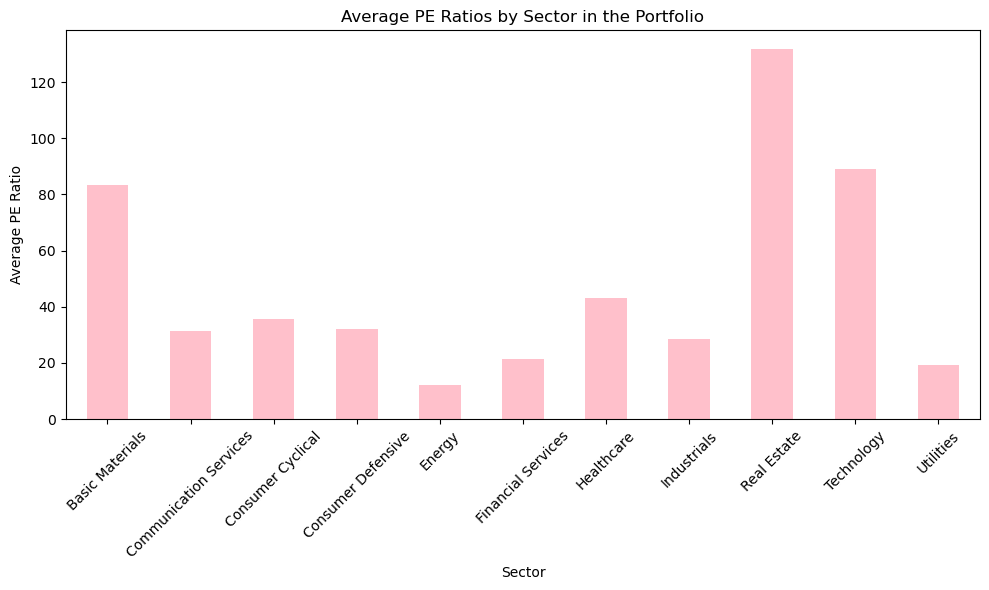

In [23]:
# Analyzing the PE Ratio distribution within the portfolio
pe_ratios = portfolio_details.groupby('sector')['PE_ratio'].mean()

# Plotting the average PE Ratios by sector within the portfolio
plt.figure(figsize=(10, 6))
pe_ratios.plot(kind='bar', color='pink')
plt.title('Average PE Ratios by Sector in the Portfolio')
plt.xlabel('Sector')
plt.ylabel('Average PE Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()